In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

In [11]:
# Load data
metadata_path = '../data/id_metadata.csv'
listening_history_path = '../data/listening_history.csv'
metadata_df = pd.read_csv(metadata_path, delimiter='\t')
df = pd.read_csv(listening_history_path, delimiter='\t')

In [12]:
df = df.iloc[:100000,]

In [14]:
df.to_csv('lh_reduced.csv')

In [4]:
unique_names_song = df.song.unique()
unique_names_user = df.user.unique()
unique_names_song.shape, unique_names_user.shape

((385,), (3,))

In [5]:
song_counts = {}

for song in unique_names_song:
    song_counts[song] = df['song'][df['song'] == song].count() / unique_names_song.shape[0]
df['interaction'] = df['song'].map(song_counts)

In [6]:
df.head()

,user,song,timestamp,interaction
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28,0.005195
1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35,0.018182
2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48,0.002597
3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52,0.005195
4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09,0.010390


3 385
Epoch 1/50


C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


200/200 [==============================] - 1s 2ms/step - loss: 0.0143 - mse: 3.0090e-04 - val_loss: 4.0723e-04 - val_mse: 3.7075e-04
Epoch 2/50
200/200 [==============================] - 0s 879us/step - loss: 2.9698e-04 - mse: 2.2317e-04 - val_loss: 3.4048e-04 - val_mse: 2.8789e-04
Epoch 3/50
200/200 [==============================] - 0s 889us/step - loss: 3.2884e-04 - mse: 2.3860e-04 - val_loss: 3.9027e-04 - val_mse: 3.6551e-04
Epoch 4/50
200/200 [==============================] - 0s 965us/step - loss: 3.5044e-04 - mse: 2.5680e-04 - val_loss: 3.2658e-04 - val_mse: 2.8648e-04
Epoch 5/50
200/200 [==============================] - 0s 945us/step - loss: 3.0635e-04 - mse: 2.2359e-04 - val_loss: 3.2398e-04 - val_mse: 2.5896e-04
Epoch 6/50
200/200 [==============================] - 0s 889us/step - loss: 2.9254e-04 - mse: 2.1622e-04 - val_loss: 2.9281e-04 - val_mse: 2.3764e-04
Epoch 7/50
200/200 [==============================] - 0s 985us/step - loss: 3.1278e-04 - mse: 2.2719e-04 - val_loss: 

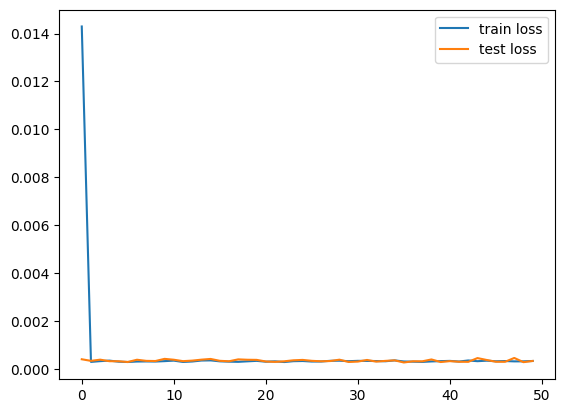

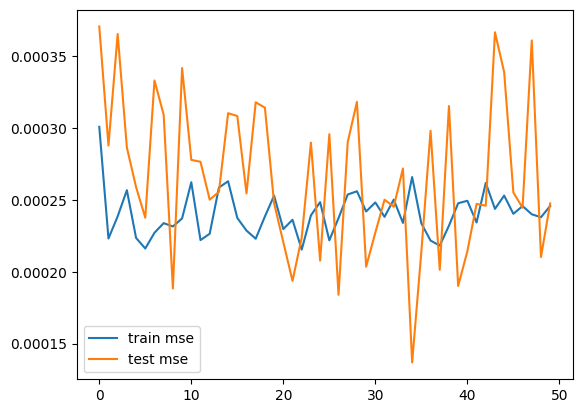

In [7]:
user_encoder = LabelEncoder()
song_encoder = LabelEncoder()
df['user_id'] = user_encoder.fit_transform(df['user'])
df['song_id'] = song_encoder.fit_transform(df['song'])

N = df.user_id.nunique() # Number of users
M = df.song_id.nunique() # Number of songs

print(N , M)

df = shuffle(df)
cutoff = int(0.8 * len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

K = 10  # Latent dimensionality
mu = df_train.interaction.mean()  # Mean interaction for normalization
epochs = 50
reg = 0.1  # Regularization penalty

u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u)  # (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m)  # (M, 1, K)

u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u)  # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m)  # (M, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding])  # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x)
dense_layer = Dense(64, activation='relu')(x)
dense_layer1 = Dense(64, activation='relu')(dense_layer)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  #optimizer=Adam(lr=0.001),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

# Now, train the model
r = model.fit(
  x=[df_train.user_id.values, df_train.song_id.values],
  y=df_train.interaction.values - mu,
  epochs=epochs,
  batch_size=4,
  validation_data=(
    [df_test.user_id.values, df_test.song_id.values],
    df_test.interaction.values - mu
  )
)

plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

# Prepare the input data
# Ensure the user and song columns are numpy arrays
user_train = df_train.user.values
song_train = df_train.song.values
user_test = df_test.user.values
song_test = df_test.song.values

# Normalize the target values
interaction_train = df_train.interaction.values - mu
interaction_test = df_test.interaction.values - mu

In [8]:
# Extract user and song IDs from the test dataset
user_ids_test = df_test.user.values
song_ids_test = df_test.song.values

print(user_ids_test)
print(song_ids_test)

# Make predictions for the test dataset
predicted_interactions_test = model.predict([user_ids_test, song_ids_test])

# Convert predictions back to the original scale
predicted_interactions_test = predicted_interactions_test.flatten() + mu

# Optionally, you can reshape the predictions to a matrix format if needed
# predicted_matrix_test = predicted_interactions_test.reshape(-1, M)  # Reshape if needed

# Evaluate the predictions
# You might want to compare these predictions with the actual interaction values
actual_interactions_test = df_test.interaction.values

# Example: Print the first few actual and predicted interactions
print("Actual interactions (test set):", actual_interactions_test[:10])
print("Predicted interactions (test set):", np.argmax(predicted_interactions_test))


['user_00c8xHqc' 'user_007XIjOr' 'user_00Y0Uqn9' 'user_00c8xHqc'
 'user_00Y0Uqn9' 'user_007XIjOr' 'user_007XIjOr' 'user_00Y0Uqn9'
 'user_00Y0Uqn9' 'user_00Y0Uqn9' 'user_00Y0Uqn9' 'user_00Y0Uqn9'
 'user_00Y0Uqn9' 'user_007XIjOr' 'user_00Y0Uqn9' 'user_00Y0Uqn9'
 'user_00Y0Uqn9' 'user_00Y0Uqn9' 'user_007XIjOr' 'user_00Y0Uqn9'
 'user_00Y0Uqn9' 'user_00Y0Uqn9' 'user_007XIjOr' 'user_007XIjOr'
 'user_00Y0Uqn9' 'user_007XIjOr' 'user_007XIjOr' 'user_00Y0Uqn9'
 'user_007XIjOr' 'user_007XIjOr' 'user_00Y0Uqn9' 'user_00c8xHqc'
 'user_00Y0Uqn9' 'user_007XIjOr' 'user_00Y0Uqn9' 'user_007XIjOr'
 'user_007XIjOr' 'user_007XIjOr' 'user_00Y0Uqn9' 'user_007XIjOr'
 'user_00Y0Uqn9' 'user_00Y0Uqn9' 'user_00Y0Uqn9' 'user_007XIjOr'
 'user_007XIjOr' 'user_007XIjOr' 'user_00Y0Uqn9' 'user_00Y0Uqn9'
 'user_007XIjOr' 'user_00Y0Uqn9' 'user_00Y0Uqn9' 'user_00Y0Uqn9'
 'user_007XIjOr' 'user_00Y0Uqn9' 'user_007XIjOr' 'user_00c8xHqc'
 'user_00Y0Uqn9' 'user_007XIjOr' 'user_00Y0Uqn9' 'user_00Y0Uqn9'
 'user_007XIjOr' 'user_00

UnimplementedError: Graph execution error:

Detected at node 'model/Cast' defined at (most recent call last):
    File "C:\Users\olko\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\olko\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\olko\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\olko\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\olko\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\olko\AppData\Local\Temp\ipykernel_7564\3439207901.py", line 9, in <module>
      predicted_interactions_test = model.predict([user_ids_test, song_ids_test])
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
      return self(x, training=False)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\functional.py", line 650, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\engine\functional.py", line 762, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'model/Cast'
Cast string to float is not supported
	 [[{{node model/Cast}}]] [Op:__inference_predict_function_52673]

In [ ]:
#original_user_ids = user_encoder.inverse_transform(df.user)
df[df.song_id == np.argmax(predicted_interactions_test)]

In [ ]:
id_tags = pd.read_csv('../data/id_tags.csv', sep='\t')
id_genres = pd.read_csv('../data/id_genres.csv', sep='\t')
id_information = pd.read_csv('../data/id_information.csv', sep='\t')
id_metadata = pd.read_csv('../data/id_metadata.csv', sep='\t')
id_lang = pd.read_csv('../data/id_lang.csv', sep='\t')

In [ ]:
id_information[id_information.id == '8v1IgNiiOwuAb2a7']

In [ ]:
df[df.user == 'user_00Y0Uqn9']